In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
# word processing libraries
from textblob import TextBlob
from collections import Counter
from keras.preprocessing.sequence import pad_sequences,Tokenizer
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
# LSTM model libraries
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout,LSTM,GlobalMaxPool1D,SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
# CNN model Libraries
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense,SpatialDropout1D, GRU, Dense,Reshape,Permute
# Naive Bayes Libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords


from nltk.stem.porter import PorterStemmer

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/MyDrive/Dataset/demonetization_tweets_kaggle.csv',encoding='ISO-8859-1')
df.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(14940, 16)

In [ ]:
df1 = pd.DataFrame(df['text'])
df1.rename(columns={'text': 'tweet'}, inplace=True)
df1.head()

,tweet
0,RT @rssurjewala: Critical question: Was PayTM ...
1,RT @Hemant_80: Did you vote on #Demonetization...
2,"RT @roshankar: Former FinSec, RBI Dy Governor,..."
3,RT @ANI_news: Gurugram (Haryana): Post office ...
4,RT @satishacharya: Reddy Wedding! @mail_today ...


In [ ]:
def clean_tweets(df):
    # Removing few characters
    df['cleaned_tweet'] = df['tweet'].replace(r'\'|\"|\,|\.|\?|\+|\-|\/|\=|\(|\)|\n|"', '', regex=True)

    # Replacing few double spaces with single space
    df['cleaned_tweet'] = df['cleaned_tweet'].replace("  ", " ")

    # Remove emoticons from the tweets
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'<ed>','', regex=True)
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'\B<U+.*>|<U+.*>\B|<U+.*>','', regex=True)

    # Convert tweets to lowercase
    df['cleaned_tweet'] = df['cleaned_tweet'].str.lower()

    # Remove user mentions
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'^(@\w+)',"", regex=True)

    # Remove 'rt' in the beginning
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'^(rt @)',"", regex=True)

    # Remove symbols
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'[^a-zA-Z0-9]', " ", regex=True)

    # Remove punctuations
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'[[]!"#$%\'()\*+,-./:;<=>?^_`{|}]+',"", regex=True)

    # Remove URLs
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'https.*$', "", regex=True)

    # Remove 'amp' in the text
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'amp', "", regex=True)

    # Remove words of length 1 or 2
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'\b[a-zA-Z]{1,2}\b', '', regex=True)

    # Remove extra spaces in the tweet
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'^\s+|\s+$', " ", regex=True)

    return df

# Example usage
df1 = clean_tweets(df1)

In [ ]:
# Function to apply sentiment analysis
def analyze_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0 and analysis.sentiment.polarity < 2:
        return 'mod_pos'
    elif analysis.sentiment.polarity >= 0 and analysis.sentiment.polarity <= 4:
        return 'high_pos'
    elif analysis.sentiment.polarity > -2 and analysis.sentiment.polarity < 0:
        return 'mod_neg'
    elif analysis.sentiment.polarity >= -4 and analysis.sentiment.polarity <= -2:
        return 'high_neg'
    else:
        return 'neutral'

# Apply sentiment analysis to the DataFrame
df1['sentiment'] = df1['cleaned_tweet'].apply(analyze_sentiment)

# Exploratory Data Analysis


>


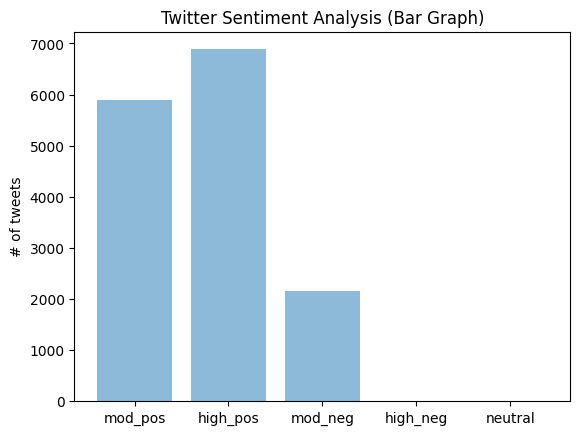

In [ ]:
# Sample values (replace these with your actual counts)


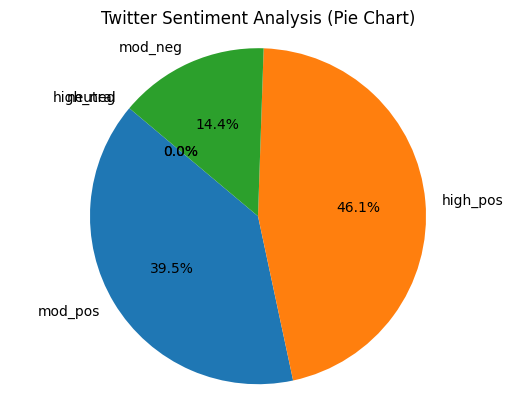

In [ ]:
plt.pie(performance, labels=objects, autopct='%1.1f%%', shadow=False, startangle=140)
plt.axis('equal')
plt.title('Twitter Sentiment Analysis (Pie Chart)')
plt.show()

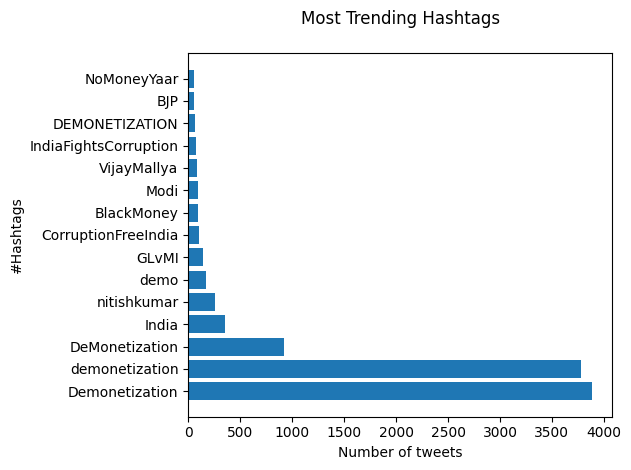

In [ ]:
# Getting top 15 hastage
df2 = pd.DataFrame(df1['tweet'])
hashtags = []
for cleaned_tweet in df2['tweet']:
    hashtags.extend(re.findall(r"#(\w+)", cleaned_tweet))
counts = Counter(hashtags)
finalcount = dict(sorted(counts.items(), key=lambda kv: kv[1], reverse=True))
countname = list(finalcount.keys())[:15]
top_counts = [finalcount[key] for key in countname]
x = np.arange(len(countname))
y = top_counts

plt.barh(x, y)
plt.title('Most Trending Hashtags\n')
plt.yticks(x, countname, rotation='horizontal')
plt.xlabel('Number of tweets')
plt.ylabel('#Hashtags')
plt.tight_layout()
plt.show()


In [ ]:
df1['sentiment'].value_counts()

high_pos    6889
mod_pos     5896
mod_neg     2155
Name: sentiment, dtype: int64

In [ ]:
df1['Sentiment'] = np.where((df1['sentiment'] == 'high_pos') | (df1['sentiment'] == 'mod_pos'), 1, 0)
df1['Sentiment'].value_counts()

1    12785
0     2155
Name: Sentiment, dtype: int64

In [ ]:
df1=df1[['cleaned_tweet','Sentiment']]
df1.head(2)

,cleaned_tweet,Sentiment
0,rssurjewala critical question was paytm info...,1
1,hemant 80 did you vote demonetization modi...,1


## **Classification of Sentimental using Naive Bayes**

In [ ]:
import nltk
nltk.download('stopwords')
ps=PorterStemmer()
corpus=[]
for i in range (0, len(df)):
    review = re.sub('[^a-z]', ' ', df1['cleaned_tweet'][i])
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if word not in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# convert text data to vector form using TFIDF VECTORIZER
cv=TfidfVectorizer(max_features=2000)
x=cv.fit_transform(corpus).toarray()

In [ ]:
y=df1['Sentiment']

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [ ]:
clf=MultinomialNB()
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('accuracy_score: ', accuracy_score(y_test, y_pred))

[[ 293  116]
 [  41 2538]]
              precision    recall  f1-score   support

           0       0.88      0.72      0.79       409
           1       0.96      0.98      0.97      2579

    accuracy                           0.95      2988
   macro avg       0.92      0.85      0.88      2988
weighted avg       0.95      0.95      0.95      2988

accuracy_score:  0.9474564926372155


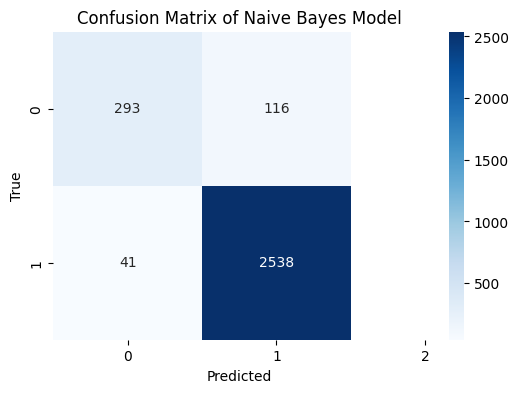

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix of Naive Bayes Model")
plt.show()

In [ ]:
# Classification using LSTM model
df1.head()

,tweet,cleaned_tweet,sentiment
0,RT @rssurjewala: Critical question: Was PayTM ...,rssurjewala critical question was paytm info...,mod_pos
1,RT @Hemant_80: Did you vote on #Demonetization...,hemant 80 did you vote demonetization modi...,high_pos
2,"RT @roshankar: Former FinSec, RBI Dy Governor,...",roshankar former finsec rbi governor cbdt ch...,high_pos
3,RT @ANI_news: Gurugram (Haryana): Post office ...,ani news gurugram haryana post office employ...,high_pos
4,RT @satishacharya: Reddy Wedding! @mail_today ...,satishacharya reddy wedding mail today cart...,high_pos


In [ ]:
df1=df1[['cleaned_tweet','sentiment']]

In [ ]:
df1['Sentiment'] = np.where((df1['sentiment'] == 'high_pos') | (df1['sentiment'] == 'mod_pos'), 'positive', 'negative')
df1['Sentiment'].value_counts()

positive    12785
negative     2155
Name: Sentiment, dtype: int64

In [ ]:
# Tokenizing the tweet column
token=Tokenizer(num_words=5000,split=' ')
token.fit_on_texts(df1['cleaned_tweet'].values)
X=token.texts_to_sequences(df1['cleaned_tweet'].values)
X=pad_sequences(X)
Y = pd.get_dummies(df1['Sentiment'])

## **Classification of Sentiments using LSTM**

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=10)

In [ ]:
modelx=Sequential()
modelx.add(Embedding(5000,240,input_length=X.shape[1]))
modelx.add(SpatialDropout1D(0.2))
modelx.add(LSTM(176,dropout=0.2,recurrent_dropout=0.2))
modelx.add(Dense(2,activation='softmax'))
print(modelx.summary)

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x7ee1185391e0>>


In [ ]:
modelx.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])
modelx.fit(X_train,y_train,epochs=10,batch_size=1024,verbose='auto')

Epoch 1/10
12/12 [==============================] - 23s 2s/step - loss: 0.5373 - accuracy: 0.8201
Epoch 2/10
12/12 [==============================] - 18s 2s/step - loss: 0.3501 - accuracy: 0.8585
Epoch 3/10
12/12 [==============================] - 18s 2s/step - loss: 0.2351 - accuracy: 0.9055
Epoch 4/10
12/12 [==============================] - 19s 2s/step - loss: 0.1376 - accuracy: 0.9499
Epoch 5/10
12/12 [==============================] - 18s 2s/step - loss: 0.0891 - accuracy: 0.9685
Epoch 6/10
12/12 [==============================] - 18s 2s/step - loss: 0.0577 - accuracy: 0.9804
Epoch 7/10
12/12 [==============================] - 20s 2s/step - loss: 0.0374 - accuracy: 0.9880
Epoch 8/10
12/12 [==============================] - 18s 2s/step - loss: 0.0258 - accuracy: 0.9918
Epoch 9/10
12/12 [==============================] - 18s 2s/step - loss: 0.0182 - accuracy: 0.9943
Epoch 10/10
12/12 [==============================] - 18s 2s/step - loss: 0.0132 - accuracy: 0.9963


In [ ]:
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/Dataset/sentimental_LSTM_finalx.h5'
modelx.save(drive_path)
print(f"Model saved to: {drive_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to: /content/drive/MyDrive/Dataset/sentimental_LSTM_finalx.h5


In [1]:
results=modelx.evaluate(X_test,y_test)
accuracy = results[1]
y_pred_prob = modelx.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert y_test_labels to 1D array
y_test_labels = np.argmax(np.array(y_test), axis=1)

NameError: ignored

In [ ]:
# Print accuracy
print(f"Accuracy of LSTM Model: {accuracy}")
# Print classification report
print("Classification Report of LSTM Model:")
print(classification_report(y_test_labels, y_pred))

Accuracy of LSTM Model: 0.9635207653045654
Classification Report of LSTM Model:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       414
           1       0.97      0.99      0.98      2574

    accuracy                           0.96      2988
   macro avg       0.94      0.90      0.92      2988
weighted avg       0.96      0.96      0.96      2988



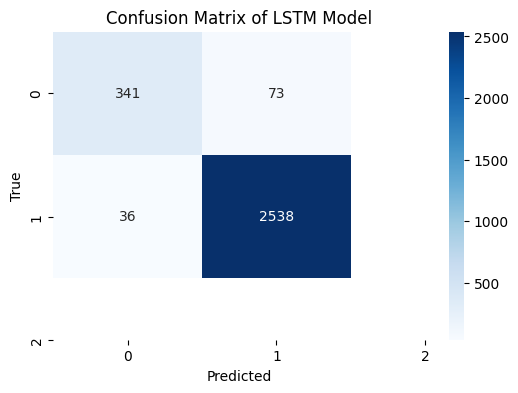

In [ ]:
cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap=" Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix of LSTM Model")
plt.show()

# Classification of Sentiments using CNN

In [ ]:
cnn_model = Sequential()
cnn_model.add(Embedding(5000, 240, input_length=X.shape[1]))
cnn_model.add(Permute((2, 1)))  # Transpose to (input_dim, steps)
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=4))
cnn_model.add(Conv1D(64, 5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=4))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(2, activation='softmax'))

In [ ]:
cnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=10, batch_size=1024, verbose='auto')

Epoch 1/10
12/12 [==============================] - 20s 2s/step - loss: 0.4863 - accuracy: 0.8543
Epoch 2/10
12/12 [==============================] - 18s 2s/step - loss: 0.3864 - accuracy: 0.8543
Epoch 3/10
12/12 [==============================] - 18s 2s/step - loss: 0.3463 - accuracy: 0.8543
Epoch 4/10
12/12 [==============================] - 22s 2s/step - loss: 0.3054 - accuracy: 0.8543
Epoch 5/10
12/12 [==============================] - 18s 2s/step - loss: 0.2483 - accuracy: 0.8543
Epoch 6/10
12/12 [==============================] - 19s 2s/step - loss: 0.1889 - accuracy: 0.8655
Epoch 7/10
12/12 [==============================] - 19s 2s/step - loss: 0.1472 - accuracy: 0.9304
Epoch 8/10
12/12 [==============================] - 18s 1s/step - loss: 0.1197 - accuracy: 0.9627
Epoch 9/10
12/12 [==============================] - 18s 2s/step - loss: 0.0986 - accuracy: 0.9835
Epoch 10/10
12/12 [==============================] - 18s 2s/step - loss: 0.0785 - accuracy: 0.9946


In [ ]:
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/Dataset/cnn_model_final.h5'
cnn_model.save(drive_path)
print(f"Model saved to: {drive_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to: /content/drive/MyDrive/Dataset/cnn_model_final.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
results=cnn_model.evaluate(X_test,y_test)
accuracy = results[1]
y_pred_prob = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(np.array(y_test), axis=1)

94/94 [==============================] - 1s 13ms/step


In [ ]:
# Print accuracy
print(f"Accuracy of CNN Model: {accuracy}")
# Print classification report
print("Classification Report of CNN Model:")
print(classification_report(y_test_labels, y_pred))

Accuracy of CNN Model: 0.9514725804328918
Classification Report of CNN Model:
              precision    recall  f1-score   support

           0       0.90      0.73      0.81       414
           1       0.96      0.99      0.97      2574

    accuracy                           0.95      2988
   macro avg       0.93      0.86      0.89      2988
weighted avg       0.95      0.95      0.95      2988



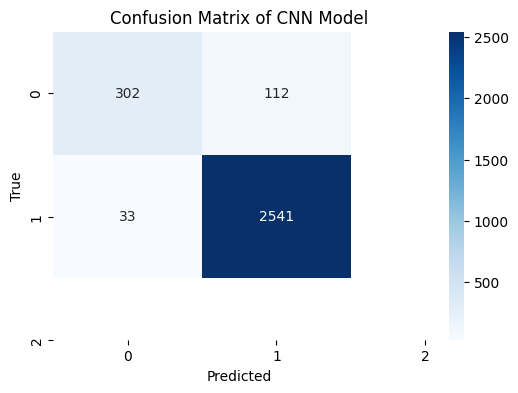

In [ ]:
cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix of CNN Model")
plt.show()